In [1]:
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import plot_roc_curve

from sklearn import model_selection
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss

In [2]:
pd.set_option('display.max_columns',None)

## Import cleaned dataset

In [17]:
pos_final_test = pd.read_csv('./pos_final_test.csv.gz', compression='gzip')

model_cols = pos_final_test.columns.str.contains('abn') | pos_final_test.columns.isin(['gender', 'age','ethnicity_AMERICAN INDIAN/ALASKA NATIVE', 'ethnicity_ASIAN','ethnicity_BLACK/AFRICAN AMERICAN', 'ethnicity_HISPANIC/LATINO','ethnicity_OTHER', 'ethnicity_UNKNOWN'])
hadm_features = pos_final_test.loc[:, model_cols]
hadm_target = pos_final_test.loc[:, 'pos']

In [41]:
# from sklearn import preprocessing
# le = preprocessing.LabelEncoder()
# hadm_features['ethnicity'] = le.fit_transform(hadm_features['ethnicity'])
# hadm_features['gender'] = le.fit_transform(hadm_features['gender'])

# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# hadm_features['age'] = scaler.fit_transform(hadm_features['age'].values.reshape(-1, 1))

/Users/brandonryu/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


## Train test split

In [43]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(hadm_features, hadm_target, test_size=.2, stratify=hadm_target, random_state=25)

In [44]:
# Over and under sample the train set
sm = SMOTE()
X_res_over, y_res_over = sm.fit_resample(X_train, y_train)

nm = NearMiss()
X_res_under, y_res_under = nm.fit_resample(X_train, y_train)

In [46]:
# check target counts
print('Target=0: ',hadm_target[hadm_target==0].count())
print('Target=1: ',hadm_target[hadm_target==1].count())

Target=0:  7539
Target=1:  1199


In [47]:
def results(model):
    '''
    Function to report on the metrics of a GridSearch model.
    Input: GridSearchCV model
    Prints: CV score, best parameters, accuracy, precision, recall, F1, confusion matrix and ROCAUC
    '''
    
#     cross validation scores
    print("Cross Validation")
    print("-" * 20)
    print("Best parameter: ", model.best_params_)
    print("Best CV score:  %.4f" % model.best_score_)

#     confusion matrix & related scores
    pred = model.best_estimator_.predict(X_test)
    print(f"Accuracy Score: {accuracy_score(y_test, pred) * 100:.2f}%")
    print("_______________________________________________")
    print("Classification Report:", end='')
    print(f"\tPrecision Score: {precision_score(y_test, pred) * 100:.2f}%")
    print(f"\t\t\tRecall Score: {recall_score(y_test, pred) * 100:.2f}%")
    print(f"\t\t\tF1 score: {f1_score(y_test, pred) * 100:.2f}%")
    print("_______________________________________________")
    print(f"Confusion Matrix: \n {confusion_matrix(y_test, pred)}\n")
    
# #     ROCAUC
#     if model.estimator.__class__== sklearn.linear_model._logistic.LogisticRegression:
#         from sklearn.metrics import roc_curve, auc

#         y_pred = model.best_estimator_.decision_function(X_test)
#         fpr, tpr, threshold = roc_curve(y_test, y_pred)
#         auc = auc(fpr, tpr)

#         print("_______________________________________________")
#         print(f"Area Under Curve: {auc:.2f}%")

#         svc_disp = plot_roc_curve(model, X_test, y_test)
#         plt.show()
#     else:
#         print('not logistic')
    svc_disp = plot_roc_curve(model, X_test, y_test)
    plt.show()

## Logistic Regression

### Basic
Try using just Abn%

Cross Validation
--------------------
Best parameter:  {'C': 1}
Best CV score:  0.8139
Accuracy Score: 80.09%
_______________________________________________
Classification Report:	Precision Score: 38.70%
			Recall Score: 77.08%
			F1 score: 51.53%
_______________________________________________
Confusion Matrix: 
 [[1215  293]
 [  55  185]]



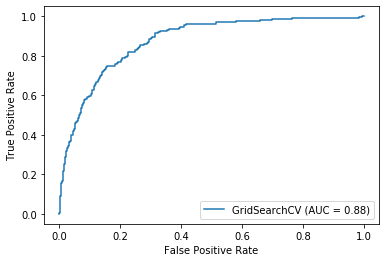

CPU times: user 9min 6s, sys: 10.6 s, total: 9min 17s
Wall time: 10min 5s


In [48]:
%%time

params ={'C':range(1, 1000, 300)}
logReg = LogisticRegression(penalty = 'l1', max_iter = 2000, class_weight = "balanced", solver = 'liblinear')

grid_log = GridSearchCV(estimator = logReg, param_grid = params, cv = 3)
grid_log.fit(X_train, y_train)
grid_log.best_score_

results(grid_log)

In [49]:
est_coefs = pd.Series(grid_log.best_estimator_.coef_[0], index=X_train.columns)

sortedCoefs = np.abs(est_coefs).sort_values(ascending=False)
sortedCoefs[sortedCoefs > 0].head(50)

('max', 50931)            4.628910
('above_max', 50931)      4.370680
('above_max', 51274)      2.325014
('max', 51274)            2.290221
('above_max', 50911)      1.875918
('max', 51237)            1.494607
('above_max', 51237)      1.208170
('max', 51006)            1.113521
('mean', 50911)           1.099120
('above_max', 51006)      1.034089
('max', 50911)            0.925828
('above_max', 50912)      0.919191
('max', 50912)            0.764165
('above_max', 51514)      0.697356
('mean', 50902)           0.686636
('above_max', 51277)      0.642939
('mean', 51222)           0.641829
age                       0.638106
('min', 51221)            0.629613
('min', 51279)            0.620897
('max', 51514)            0.601722
('mean', 51250)           0.600632
('max', 50882)            0.597973
('mean', 50970)           0.544205
('max', 51222)            0.529938
('max', 50970)            0.513694
('mean', 51265)           0.500837
('max', 51277)            0.496362
('min', 51248)      

### Over Sampling using SMOTE

In [50]:
%%time
params ={'C':range(1, 1000, 300)}
logReg = LogisticRegression(penalty = 'l1', max_iter = 2000, class_weight = "balanced", solver = 'liblinear')

grid_log_over = GridSearchCV(estimator = logReg, param_grid = params, cv = 3)
grid_log_over.fit(X_res_over, y_res_over)
grid_log_over.best_score_

CPU times: user 6min 1s, sys: 6.4 s, total: 6min 7s
Wall time: 6min 35s


0.841817584546801

Cross Validation
--------------------
Best parameter:  {'C': 301}
Best CV score:  0.8418
Accuracy Score: 81.41%
_______________________________________________
Classification Report:	Precision Score: 40.23%
			Recall Score: 72.92%
			F1 score: 51.85%
_______________________________________________
Confusion Matrix: 
 [[1248  260]
 [  65  175]]



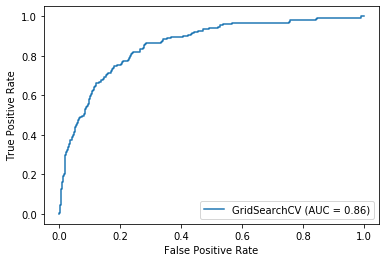

('max', 50931)            7.261986
('above_max', 50931)      6.879963
('max', 51274)            6.134778
('above_max', 51274)      5.401901
('max', 51237)            5.301566
('above_max', 51237)      4.354405
('max', 50861)            3.636481
('above_max', 50861)      3.366922
('mean', 51274)           2.479280
('below_min', 51222)      2.357819
('mean', 51237)           2.282629
('above_max', 50911)      2.104058
gender                    2.078676
('mean', 51221)           1.948805
('min', 51222)            1.837817
('min', 51221)            1.799232
('above_max', 50912)      1.727231
('max', 50912)            1.706995
('max', 50878)            1.447134
('max', 51006)            1.438191
('min', 51274)            1.437068
('above_max', 51006)      1.424652
('mean', 50911)           1.242730
('min', 51237)            1.204851
('above_max', 51514)      1.196649
('max', 51514)            1.140737
('mean', 50902)           1.090284
('mean', 51478)           1.070918
('mean', 50878)     

In [51]:
results(grid_log_over)

est_coefs = pd.Series(grid_log_over.best_estimator_.coef_[0], index=X_train.columns)
sortedCoefs = np.abs(est_coefs).sort_values(ascending=False)
sortedCoefs[sortedCoefs > 0].head(50)

### Under Sampling using Near Miss

In [ ]:
%%time
params ={'C':range(1, 1000, 300)}
logReg = LogisticRegression(penalty = 'l1', max_iter = 2000, class_weight = "balanced", solver = 'liblinear')

grid_log_under = GridSearchCV(estimator = logReg, param_grid = params, cv = 3)
grid_log_under.fit(X_res_under, y_res_under)
grid_log_under.best_score_

In [ ]:
results(grid_log_under)

est_coefs = pd.Series(grid_log_under.best_estimator_.coef_[0], index=X_train.columns)
sortedCoefs = np.abs(est_coefs).sort_values(ascending=False)
sortedCoefs[sortedCoefs > 0].head(50)

## Random Forest

### Basic

In [ ]:
%%time
param_grid={'criterion': ['entropy','gini'],
            'n_estimators': range(1,500,50),
            'max_depth': range(10,110,20)
            }

grid_rf = model_selection.GridSearchCV(estimator = RandomForestClassifier(), param_grid = param_grid, cv=3)
grid_rf.fit(X_train, y_train)

In [ ]:
results(grid_rf)
grid_rf.best_estimator_.feature_importances_

### Over Sampling using SMOTE

In [ ]:
%%time
param_grid={'criterion': ['entropy','gini'],
            'n_estimators': range(1,31,10),
            'max_depth': range(10,110,20)
            }

grid_rf_over = model_selection.GridSearchCV(estimator = RandomForestClassifier(), param_grid = param_grid, cv=3)
grid_rf_over.fit(X_res_over, y_res_over)

results(grid_rf_over)

### Under Sampling using Near Miss

In [ ]:
%%time
param_grid={'criterion': ['entropy','gini'],
            'n_estimators': range(1,31,10),
            'max_depth': range(10,110,20)
            }

grid_rf_under = model_selection.GridSearchCV(estimator = RandomForestClassifier(), param_grid = param_grid, cv=3)
grid_rf_under.fit(X_res_under, y_res_under)

results(grid_rf_under)

## Gradient Boost

In [ ]:
# additive approach using 1. n_estimators 2. max_depth, min_samples
# perhaps use randomsearch instead of gridsearch
# look at area under curve (AUC)

### basic

In [ ]:
%%time
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

param_grid={'n_estimators':range(20,81,20),
            'max_depth':range(5,16,4),
            'min_samples_split':range(20,100,30),
            'max_features':range(7,20,5),
            }

grid_gb = model_selection.GridSearchCV(estimator = GradientBoostingClassifier(), param_grid = param_grid, cv=3)
grid_gb.fit(X_train, y_train)

results(grid_gb)

### Over Sampling using SMOTE¶

In [ ]:
%%time
param_grid={'n_estimators':range(20,81,20),
            'max_depth':range(5,16,4),
            'min_samples_split':range(20,100,30),
            'max_features':range(7,20,5),
            }

grid_gb_over = model_selection.GridSearchCV(estimator = GradientBoostingClassifier(), param_grid = param_grid, cv=3)
grid_gb_over.fit(X_res_over, y_res_over)

results(grid_gb_over)

### Under Sampling using Near Miss

In [ ]:
%%time
param_grid={'n_estimators':range(20,81,20),
            'max_depth':range(5,16,4),
            'min_samples_split':range(20,100,30),
            'max_features':range(7,20,5),
            }

grid_gb_under = model_selection.GridSearchCV(estimator = GradientBoostingClassifier(), param_grid = param_grid, cv=3)
grid_gb_under.fit(X_res, y_res)

results(grid_gb_under)